## VQ-VAE and Pixel CNN

Code: https://github.com/probml/pyprobml/tree/master/scripts/vae

## Installs


In [1]:
!pip install pytorch_lightning

     |████████████████████████████████| 916 kB 7.4 MB/s 
     |████████████████████████████████| 272 kB 43.0 MB/s 
     |████████████████████████████████| 118 kB 54.7 MB/s 
     |████████████████████████████████| 636 kB 55.7 MB/s 
     |████████████████████████████████| 829 kB 59.7 MB/s 
     |████████████████████████████████| 1.3 MB 58.8 MB/s 
     |████████████████████████████████| 142 kB 67.8 MB/s 
     |████████████████████████████████| 294 kB 60.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=512c42005d2ea3d6a8232837a1d83569854dcf778418cd0d9ee346c538899ac0
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

## Clone 

In [2]:
!git clone 'https://github.com/probml/pyprobml.git'

Cloning into 'pyprobml'...
remote: Enumerating objects: 12943, done.
remote: Counting objects: 100% (1688/1688), done.
remote: Compressing objects: 100% (899/899), done.
remote: Total 12943 (delta 980), reused 1393 (delta 775), pack-reused 11255
Receiving objects: 100% (12943/12943), 630.58 MiB | 34.98 MiB/s, done.
Resolving deltas: 100% (7197/7197), done.


In [3]:
%cd '/content/pyprobml/scripts/vae'

/content/pyprobml/scripts/vae


## Imports

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Ftn
from torchvision.utils import make_grid
import os
from assembler import get_config, assembler
from experiment import *

## Load the pixelCNN  and vq-vae model checkpoints from public url of gcp bucket

#### vae model

In [5]:
!mkdir /content/pyprobml/scripts/vae/model 

In [6]:
!wget 'https://storage.googleapis.com/probml_data/vae_checkpoints/vq_vae_celeba_conv.ckpt' -P /content/pyprobml/scripts/vae/model/

--2021-08-17 11:22:58--  https://storage.googleapis.com/probml_data/vae_checkpoints/vq_vae_celeba_conv.ckpt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38867376 (37M) [application/octet-stream]
Saving to: ‘/content/pyprobml/scripts/vae/model/vq_vae_celeba_conv.ckpt’

vq_vae_celeba_conv. 100%[===================>]  37.07M  56.5MB/s    in 0.7s    

2021-08-17 11:22:59 (56.5 MB/s) - ‘/content/pyprobml/scripts/vae/model/vq_vae_celeba_conv.ckpt’ saved [38867376/38867376]



In [7]:
config = get_config('./configs/vq_vae.yaml')
vae = assembler(config, "training")

In [8]:
vae.load_state_dict(torch.load(os.path.join('./model/', config["pixel_params"]["pretrained_path"])))

<All keys matched successfully>

#### pixelcnn model

In [9]:
!wget 'https://storage.googleapis.com/probml_data/vae_checkpoints/pixel_cnn_celeba_conv.ckpt' -P /content/pyprobml/scripts/vae/model/

--2021-08-17 11:22:59--  https://storage.googleapis.com/probml_data/vae_checkpoints/pixel_cnn_celeba_conv.ckpt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74304735 (71M) [application/octet-stream]
Saving to: ‘/content/pyprobml/scripts/vae/model/pixel_cnn_celeba_conv.ckpt’

pixel_cnn_celeba_co 100%[===================>]  70.86M  88.3MB/s    in 0.8s    

2021-08-17 11:23:00 (88.3 MB/s) - ‘/content/pyprobml/scripts/vae/model/pixel_cnn_celeba_conv.ckpt’ saved [74304735/74304735]



In [10]:
num_residual_blocks = config["pixel_params"]["num_residual_blocks"]
num_pixelcnn_layers = config["pixel_params"]["num_pixelcnn_layers"]
num_embeddings = config["vq_params"]["num_embeddings"]
hidden_dim = config["pixel_params"]["hidden_dim"]

In [11]:
pixel_cnn_raw = PixelCNN(hidden_dim, num_residual_blocks, num_pixelcnn_layers, num_embeddings)
pixel_cnn = PixelCNNModule(pixel_cnn_raw,
                            vae,
                            config["pixel_params"]["height"],
                            config["pixel_params"]["width"],
                            config["pixel_params"]["LR"])

In [12]:
pixel_cnn.load_state_dict(torch.load(os.path.join('./model/', config["pixel_params"]["save_path"])))

<All keys matched successfully>

In [13]:
p_pixel_cnn = PixelCNNModule(pixel_cnn, vae, config["pixel_params"]["height"], config["pixel_params"]["width"],config["pixel_params"]["LR"])

## Get samples 

In [14]:
p_pixel_cnn = pixel_cnn.to("cuda")
N = 16
priors = p_pixel_cnn.get_priors(N)
generated_samples = p_pixel_cnn.generate_samples_from_priors(priors)

## Show grid


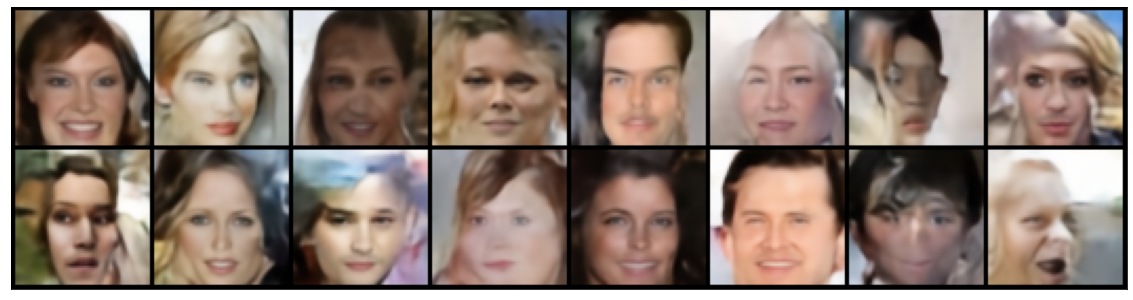

In [15]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):

    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20,20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = Ftn.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

grid = make_grid(generated_samples)
show(grid)

## Codebook Sampling

In [16]:
def generate_samples_from_priors_cpu(self, priors):
        priors = priors.to(self.device)
        priors_ohe = F.one_hot(priors.view(-1, 1).to("cpu").long(), num_classes=self.vector_quantizer.K).squeeze().float()
        quantized = torch.matmul(priors_ohe, self.vector_quantizer.embedding.weight)  # [BHW, D]
        quantized = quantized.view(-1, self.height, self.width, self.vector_quantizer.D).permute(0, 3, 1, 2)
        with torch.no_grad():
            return self.decoder(quantized)

In [17]:
p_pixel_cnn_cpu = pixel_cnn.to("cpu")
N = 8
priors = p_pixel_cnn.get_priors(N)

In [18]:
generated_cpu_samples = generate_samples_from_priors_cpu(p_pixel_cnn, priors)

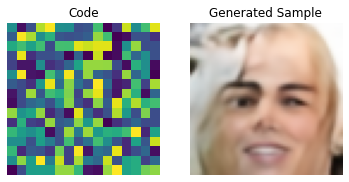

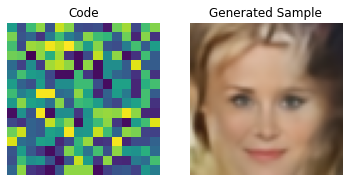

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


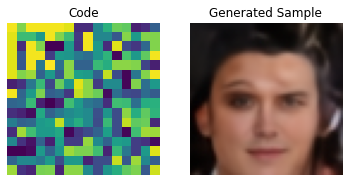

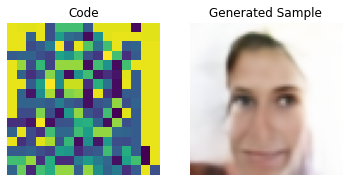

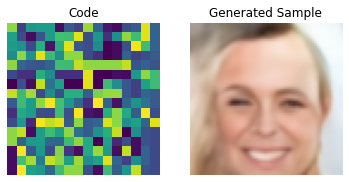

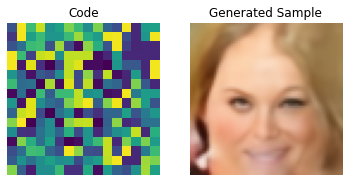

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


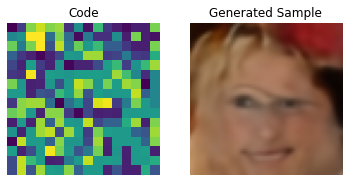

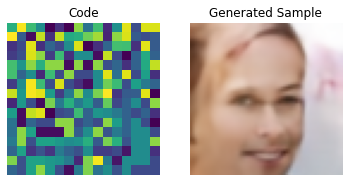

In [19]:
import matplotlib.pyplot as plt

for i in range(N):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i].detach().cpu())
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_cpu_samples[i].detach().permute(1,2,0).squeeze())
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()